In [85]:
import pandas as pd
import numpy as np
import torch
from torch import Tensor
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, CosineKernel
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import os

## Hyperparameter Setting

In [86]:
num_grids = 50
num_latents_per_kernel = 100
num_outputs = 300 #int(1e3)
noise_variance = 0.05

inputs = Tensor(np.linspace(-10, 10, num_grids))

## Kernels

In [87]:
# Kernel1: Scaled RBF kernel

kernel1 = ScaleKernel(RBFKernel())
kernel1.base_kernel.lengthscale = Tensor([[1.5]])
kernel1.outputscale = Tensor([0.9])
# TODO: why add_jitter is needed? Strange! 
cov_matrix1 = kernel1(inputs).add_jitter(1e-4).to_dense().detach()

mu1 = Tensor([0]* num_grids)
gaussian_dist_1 = MultivariateNormal(mu1, cov_matrix1).sample([num_latents_per_kernel]) # torch.Size([100, 500])

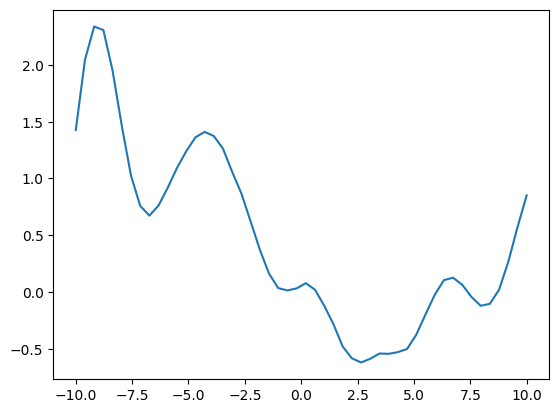

In [88]:
plt.plot(inputs, gaussian_dist_1[87])

In [89]:
# Kernel2: Scaled RBF kernel

kernel2 = ScaleKernel(RBFKernel())
kernel2.base_kernel.lengthscale = Tensor([[1.7]])
kernel2.outputscale = Tensor([0.7])
# TODO: why add_jitter is needed? Strange! 
cov_matrix2 = kernel2(inputs).add_jitter(1e-4).to_dense().detach()

mu2 = Tensor([0]* num_grids)
gaussian_dist_2 = MultivariateNormal(mu2, cov_matrix2).sample([num_latents_per_kernel]) # torch.Size([100, 500])

In [90]:
'''
# Kernel2: Matern 3/2

kernel2 = ScaleKernel(MaternKernel(nu=1.5))
kernel2.outputscale = Tensor([0.8])
cov_matrix2 = kernel2(inputs).to_dense().detach()

mu2 = Tensor([0]* num_grids)
gaussian_dist_2 = MultivariateNormal(mu2, cov_matrix2).sample([num_latents_per_kernel]) # torch.Size([100, 500])
'''

'\n# Kernel2: Matern 3/2\n\nkernel2 = ScaleKernel(MaternKernel(nu=1.5))\nkernel2.outputscale = Tensor([0.8])\ncov_matrix2 = kernel2(inputs).to_dense().detach()\n\nmu2 = Tensor([0]* num_grids)\ngaussian_dist_2 = MultivariateNormal(mu2, cov_matrix2).sample([num_latents_per_kernel]) # torch.Size([100, 500])\n'

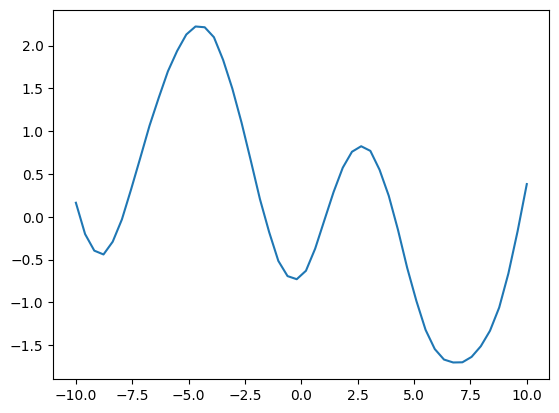

In [91]:
plt.plot(inputs, gaussian_dist_2[37])

In [92]:
'''
# Kernel3: Cosine Kernel
kernel3 = ScaleKernel(CosineKernel())
kernel3.period_length = 5
cov_matrix3 = kernel3(inputs).add_jitter(1e-4).to_dense().detach()

mu3 = Tensor([0]* num_grids)
gaussian_dist_3 = MultivariateNormal(mu3, cov_matrix3).sample([num_latents_per_kernel]) # torch.Size([500])
'''

'\n# Kernel3: Cosine Kernel\nkernel3 = ScaleKernel(CosineKernel())\nkernel3.period_length = 5\ncov_matrix3 = kernel3(inputs).add_jitter(1e-4).to_dense().detach()\n\nmu3 = Tensor([0]* num_grids)\ngaussian_dist_3 = MultivariateNormal(mu3, cov_matrix3).sample([num_latents_per_kernel]) # torch.Size([500])\n'

## Output functions

In [93]:
random_weights_k1 = torch.randn(num_latents_per_kernel, num_outputs) 
random_weights_k2 = torch.randn(num_latents_per_kernel, num_outputs)
assert random_weights_k2.shape == random_weights_k1.shape == torch.Size([num_latents_per_kernel, num_outputs])

In [94]:
# before applied with gaussian likelihood (gaussian noise)
synth_data = 1 *  (random_weights_k1.transpose(-1,-2) @ gaussian_dist_1  + random_weights_k2.transpose(-1,-2) @ gaussian_dist_2) # of shape (num_outputs, num_grids)

# add with gaussian noise
noise = torch.randn_like(synth_data) * np.sqrt(noise_variance)
synth_data = synth_data + noise
print('max:', synth_data.max())
print('min:', synth_data.min())
synth_data_ = synth_data.reshape(-1)

max: tensor(2.8194)
min: tensor(-2.6681)


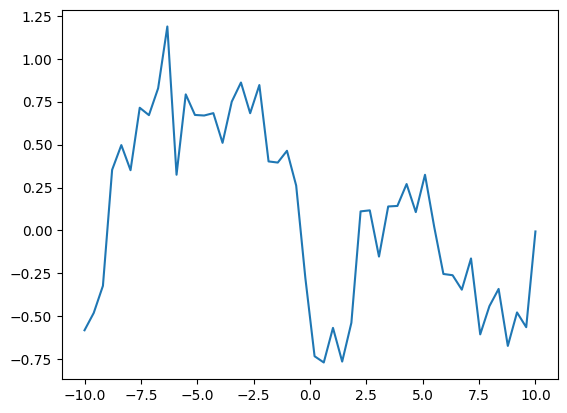

In [99]:
plt.plot(inputs, synth_data[123])

## Storing data

In [96]:
store_path = '/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/data/synth_regression'
new_folder_path = f'{store_path}/LMC_ninputs_{num_grids}_num_outputs_{num_outputs}'
os.makedirs(new_folder_path, exist_ok=True)

pd.DataFrame(inputs.numpy()).to_csv(f'{new_folder_path}/inputs.csv', index=False)
pd.DataFrame(synth_data_.numpy()).to_csv(f'{new_folder_path}/data.csv', index=False)
